# Summarize raster values within a polygon

This method relies on the `zonal_stats` function of the `rasterstats` library. 

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import xarray as xr
from rasterstats import zonal_stats

This example makes use of the "Sea Ice Indicators" dataset to provide the rasters we want to summarize over, `nsidc_0051_1979-2019_fubu.nc`:

In [2]:
fubu_fp = "data/nsidc_0051_1979-2019_fubu.nc"
fubu = xr.load_dataset("data/nsidc_0051_1979-2019_fubu.nc")

This will rely on the MASIE regions for some polygons to extract to. 

Since the `fubu` dataset is in EPSG:3411, we must project the polygons via `to_crs()` method:

In [3]:
masie_polys = gpd.read_file("ancillary/shp/MASIE_regions_4326.shp").to_crs(3411)

`zonal_stats` function requires the following:

1. DataFrame of polygons
2. raster / 2-D array 
3. affine transformation of the raster
4. summary functions

We will just use one polygon to start, so subset the DataFrame:

(Important to remember double brakcets on the `.loc` call to retain DataFrame object.)

In [4]:
central_arctic_poly = masie_polys.set_index("Name").loc[["Central Arctic"]]
central_arctic_poly

,geometry
Name,
Central Arctic,"POLYGON ((-1235162.383 -515666.718, -1010525.2..."


We can get the affine transform, which maps array indices to coordinates, via `rasterio` by opening a single variable of the netCDF:

In [5]:
with rio.open(f"netcdf:{fubu_fp}:breakup_end") as src:
    affine = src.meta["transform"]

Select a variable and time slice to summarize over (i.e., get a raster):

In [6]:
 arr = fubu["breakup_end"].sel(year=1979).values

Create a summarizing function. For now, instead of actually doing anything to the data, this just returns the masked array from the intersecting of the raster and polygon.

In [7]:
def return_obj(obj):
    """Return the single input object
    
    For use with returning the masked array 
    created by zonal_stats()"""
    return obj

Call `zonal_stats` with the `add_stats` parameter as a dict of summarizing functions. ommitting a `stats` parameter returns all standard `stats`.

In [8]:
zs = zonal_stats(
    central_arctic_poly,
    arr,
    affine=affine,
    nodata=np.nan,
    add_stats={"marr": return_obj},
)

zs

[{'min': 155.0,
  'max': 237.0,
  'mean': 215.915611814346,
  'count': 237,
  'marr': masked_array(
    data=[[--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          ...,
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --]],
    mask=[[ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          ...,
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True],
          [ True,  True,  True, ...,  True,  True,  True]],
    fill_value=1e+20)}]

`zonal_stats` clips the raster to the extent of the polygon (left), creates a mask of all values outside the polygon and nodata values inside of it (middle) to get a final set of data that would be summarized over with a typical function (right). 

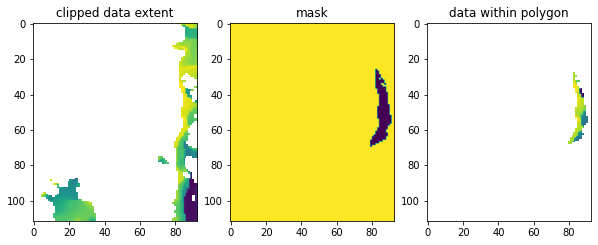

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

axs[0].imshow(zs[0]["marr"].data)
axs[0].set_title("clipped data extent")

axs[1].imshow(zs[0]["marr"].mask)
axs[1].set_title("mask")

axs[2].imshow(zs[0]["marr"])
axs[2].set_title("data within polygon")

plt.show()